# Cardiovascular Disease Prediction (III Modeling)

#### Project Overview

Coronary Heart Disease (CHD) remains one of the leading causes of death globally. Predicting the 10-year risk of CHD based on demographic, behavioral, and clinical data is essential for preventive healthcare.

- [I Data Cleaning](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_I_DataCleaning.ipynb)
- [II EDA](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_II_EDA.ipynb)
- **[III Modeling](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_III_Modeling.ipynb)**  

This is a 3rd part of the project that builds and compares several machine learning models to estimate CHD risk using data from the Framingham Heart Study.

#### Objectives
- Develop predictive models for 10-year CHD risk (TenYearCHD = 1).
- Compare Logistic Regression and Random Forest models under different resampling and tuning strategies.
- Evaluate how feature engineering and balancing methods (e.g., SMOTE) influence model performance.
- Identify key predictive features for clinical interpretability.

#### Data Preparation
- The dataset was split into training and testing sets with stratified sampling to preserve the class imbalance ratio.
- Feature engineering introduced clinically relevant features such as:
    - `is_obese` – BMI above threshold
    - `pulse_pressure` – systolic minus diastolic BP
    - `is_high_glucose` – derived from glucose levels
- Categorical and numerical variables were preprocessed using unified pipelines.

#### Target Variable

The binary target variable is `TenYearCHD`, indicating whether an individual developed coronary heart disease within 10 years (1 = Yes, 0 = No).

#### Evaluation Metrics

| **Metric** | **Interpretation** | **Importance in this context** |
|:--|:--|:--|
| **Accuracy** | Overall proportion of correctly classified cases. | Provides a general measure of correctness. |
| **Precision** | Of all predicted CHD cases, how many are actually CHD. | Important when false positives (unnecessary alerts) are costly. |
| **Recall (Sensitivity)** | Of all actual CHD cases, how many were correctly predicted. | **Primary focus** — minimizing false negatives is critical since missing a high-risk patient is more dangerous than a false alarm. |
| **F1-score** | Harmonic mean of Precision and Recall. | Provides a single measure of performance when both Precision and Recall are important. |
| **ROC AUC** | Area under the Receiver Operating Characteristic curve. | Indicates the model’s overall ability to distinguish between CHD and non-CHD. |  


In this medical context, **Recall** is prioritized over Precision: it’s better to flag more potential CHD cases (even with some false alarms) than to miss individuals who are genuinely at risk.

#### Why Keep All Columns (Feature Inclusion Rationale)
Including all available features (demographic, behavioral, and medical) helped the model capture a more complete clinical picture of CHD risk. 

**Pros:**
- Captures all potential interactions and non-linear effects.
- Enables models to detect subtle patterns that limited features might miss.  
- Retains weak but complementary predictors that can boost recall or AUC. 
- Maintains interpretability — Logistic Regression coefficients stay clinically meaningful for assessing CHD risk.

**Cons:**
- Possible noise or redundancy — Some features may add limited value or increase variance.  
- Correlated predictors can affect coefficient stability in linear models.  
- Slightly longer training time, but negligible for this dataset.

**Empirical Justification:**  
After testing recall stability, the **Logistic Regression (Balanced + Feature Engineering)** model showed:
- **Training Recall:** 0.657  
- **Test Recall:** 0.696 (Δ = 0.039)  
- **5-Fold Cross-Validation Recall:** 0.655 ± 0.034  

These consistent results across training, testing, and cross-validation confirm that **including all features improved recall without overfitting**.  

Therefore, retaining all columns is justified, as it enhances sensitivity (recall) while maintaining strong overall performance.

---

#### Key Results Summary

| **Model** | **Accuracy** | **Precision** | **Recall** | **F1** | **ROC AUC** |
|:--|:--:|:--:|:--:|:--:|:--:|
| Logistic Regression (Balanced + Feature Engineered) | 0.721 | 0.310 | **0.696** | 0.429 | **0.757** |
| Random Forest (SMOTE + Feature Engineered + Tuned) | 0.758 | 0.309 | **0.490** | 0.379 | **0.734** |

#### Conclusion & Recommendation

- **Logistic Regression (Balanced + Feature Engineered)** achieved the best balance between recall and ROC AUC, identifying 69.6% of CHD cases correctly.
- Random Forest showed higher accuracy but lower sensitivity, meaning it may miss at-risk patients.
- Future work could include:
    - Ensemble or stacking approaches combining multiple classifiers.
    - Validation on external datasets to test generalizability.

---

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Inerpretability
import shap

In [2]:
# Plot style
def set_plot_theme():
    plt.style.use("seaborn-v0_8-dark")
    sns.set_theme(
        style="dark",
        palette="deep",
        font_scale=1
    )
    plt.rcParams["figure.figsize"] = (6, 4)

set_plot_theme()

---

### 1. Load Cleaned Data

In [3]:
df_chd = pd.read_parquet("df_chd_cleaned.parquet")

In [4]:
df_chd.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2,1,1,3.0,0,0,0,0,221.0,148.0,85.0,24.68,90.0,80.0,1
1,36,4,0,0,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1,1,1,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1,0,1,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1,1,1,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [5]:
df_copy = df_chd.copy()

In [6]:
categories = ["education", "sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD"]

for col in categories:
    df_copy[col] = df_copy[col].astype("category")

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              3389 non-null   int64   
 1   education        3389 non-null   category
 2   sex              3389 non-null   category
 3   is_smoking       3389 non-null   category
 4   cigsPerDay       3389 non-null   float64 
 5   BPMeds           3389 non-null   category
 6   prevalentStroke  3389 non-null   category
 7   prevalentHyp     3389 non-null   category
 8   diabetes         3389 non-null   category
 9   totChol          3389 non-null   float64 
 10  sysBP            3389 non-null   float64 
 11  diaBP            3389 non-null   float64 
 12  BMI              3389 non-null   float64 
 13  heartRate        3389 non-null   float64 
 14  glucose          3389 non-null   float64 
 15  TenYearCHD       3389 non-null   category
dtypes: category(8), float64(7), int64(1)
memory usa

In [8]:
df = df_copy.copy()

---

### 2. Modeling

#### 2.1. Define Features and Target

In [9]:
numerical_feats = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]
categorical_feats = ["education", "sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]

In [10]:
X = df[categorical_feats + numerical_feats]
y = df["TenYearCHD"].astype(int)

#### 2.2. Analyze Target Variable Distribution

In [11]:
counts = y.value_counts()
percentages = y.value_counts(normalize=True).mul(100).round(2)
chd_df = pd.DataFrame({"Counts": counts, "%": percentages})

In [12]:
print(chd_df)

            Counts      %
TenYearCHD               
0             2879  84.95
1              510  15.05


The dataset is **`imbalanced`** (84.95%/15.05% split). Stratification is necessary for the train-test split.

#### 2.3. Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

By adding **`stratify=y`**, we tell the function to preserve the percentage of each class from y. Since the original data y has a **84.95%/15.05%** split, the function will ensure both the training and testing sets have that same split.

#### 2.4. Verify the Split

In [14]:
train_dist = y_train.value_counts(normalize=True).mul(100).round(2)
test_dist = y_test.value_counts(normalize=True).mul(100).round(2)

In [15]:
verification_df = pd.DataFrame({
    "Original %": percentages,
    "Train %": train_dist,
    "Test %": test_dist
})

In [16]:
print(verification_df)

            Original %  Train %  Test %
TenYearCHD                             
0                84.95    84.95   84.96
1                15.05    15.05   15.04


---

#### 2.5. Preprocessing

Before we can train our models, the feature set must be transformed into a suitable numerical format.

- **Categorical Features:** Convert into a numerical format using `OneHotEncoder`.
- **Numerical Features:** Scaled using `StandardScaler`.

We will use `ColumnTransformer` to apply these different transformations to the correct columns in a single step.

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_feats),
        ("numerical", StandardScaler(), numerical_feats)
    ]
)

---

#### 2.6. Modeling Approach and Evaluation

Our goal is to predict `TenYearCHD=1`, an imbalanced classification problem where CHD cases are much less common than non-cases.

Our modeling strategy will be as follows:

1. **Establish a Baseline:** We will first implement a DummyClassifier to serve as a sanity check. Any effective model must outperform this baseline.
2. **Compare Imbalance Strategies:** We will evaluate models using two distinct strategies to handle the class imbalance.
3. **Evaluate Performance:** **`Accuracy, Precision, Recall, F1-score, and ROC AUC.`**

---

#### 2.7. Candidate Models and Imbalance Strategies

We will evaluate two classification algorithms:

- **Logistic Regression**
- **Random Forest**

To address the class imbalance, we will train each of these models using the two strategies:

1. **Class Weights** - adjusts the model's loss function to penalize misclassifications of the minority class more heavily. Set `class_weight='balanced'` parameter in the model **→ no synthetic data**
2. **Synthetic Minority Oversampling Technique (SMOTE)** - oversampling the minority class in the training data. It generates new, synthetic data points for the minority class (CHD positive) to create a more balanced dataset for the model to learn from.

In [18]:
all_models = {
    "Dummy (most_frequent)": (DummyClassifier(strategy="most_frequent"), False),
    "Logistic Regression (balanced)": (LogisticRegression(max_iter=1000, class_weight="balanced"), False),
    "Random Forest (balanced)": (RandomForestClassifier(n_estimators=150, max_depth=10, class_weight="balanced", random_state=42), False),
    "Logistic Regression (SMOTE)": (LogisticRegression(max_iter=1000, random_state=42), True),
    "Random Forest (SMOTE)": (RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42), True),
}

In [19]:
results = []

In [20]:
# Evaluation
for name, (model, use_smote) in all_models.items():
    
    if use_smote:
        pipe = ImbPipeline(steps=[("preprocessor", preprocessor),
                                  ("smote", SMOTE(random_state=42)),
                                  ("model", model)])
    else:
        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", model)])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    
    y_proba = None
    if hasattr(pipe, "predict_proba"):
        # The [:, 1] select probability for the positive class (TenYearCHD=1)
        y_proba = pipe.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else 0.5
    })

In [21]:
results_df = pd.DataFrame(results).set_index("Model").round(3)
results_df.index.name = "Model (Positive class: TenYearCHD=1)"
results_df

,Accuracy,Precision,Recall,F1,ROC AUC
Model (Positive class: TenYearCHD=1),,,,,
Dummy (most_frequent),0.850,0.000,0.000,0.000,0.500
Logistic Regression (balanced),0.709,0.294,0.667,0.408,0.751
Random Forest (balanced),0.829,0.306,0.108,0.159,0.704
Logistic Regression (SMOTE),0.706,0.288,0.647,0.399,0.738
Random Forest (SMOTE),0.794,0.302,0.284,0.293,0.692


**Keep in mind:** All metrics (Precision, Recall, F1, ROC AUC) are calculated with the **positive class : `TenYearCHD = 1`** (patients who develop CHD).

---

#### 2.8. ROC Curve Comparison

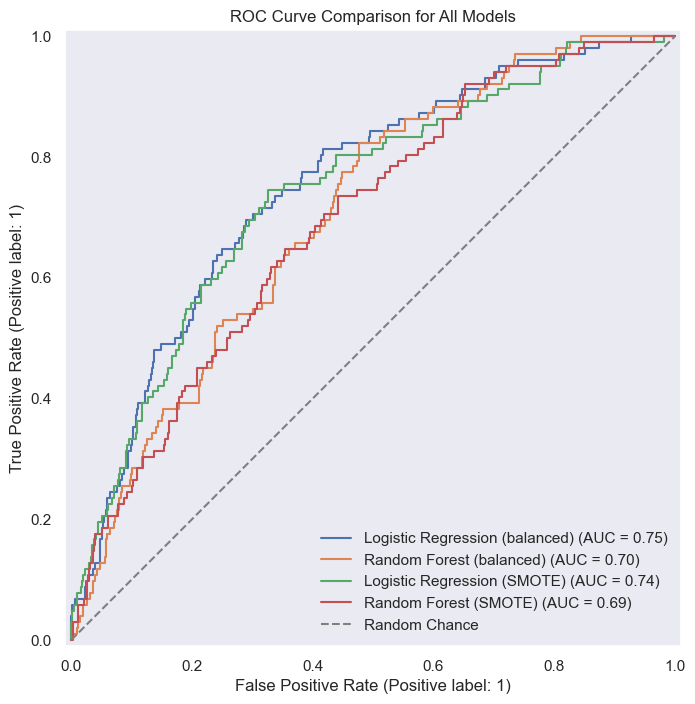

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
for name, (model, use_smote) in all_models.items():
    
    if "Dummy" in name:
        continue
        
    if use_smote:
        pipe = ImbPipeline(steps=[("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("model", model)])
    else:
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
        
    pipe.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name, ax=ax)

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random Chance")
ax.set_title("ROC Curve Comparison for All Models")
ax.legend()
plt.show()

`Interpretation:` A better model’s ROC curve lies closer to the top-left corner, indicating high true positives and low false positives.
- AUC = 1.0 → perfect classifier
- AUC = 0.5 → no predictive power (random guessing)

#### 2.9. Confusion Matrices for All Models

In [23]:
models_to_plot = [item for item in all_models.items() if "Dummy" not in item[0]]

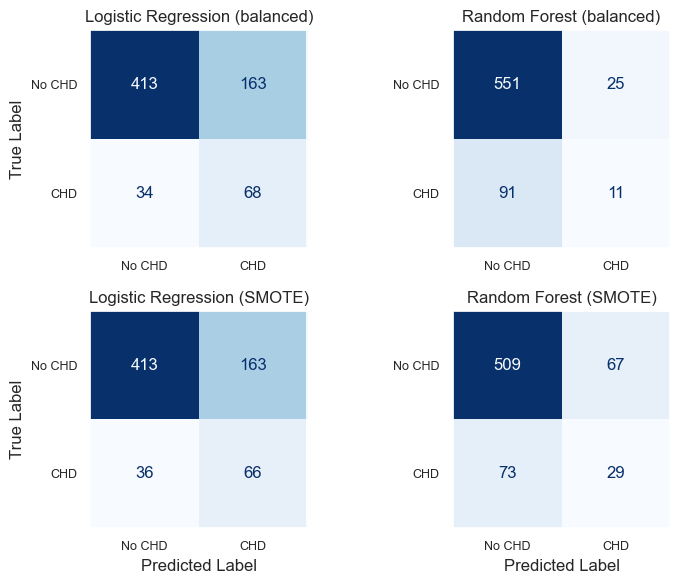

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for idx, ((name, (model, use_smote)), ax) in enumerate(zip(models_to_plot, axes)):
    pipe = ImbPipeline([("preprocessor", preprocessor),
                        ("smote", SMOTE(random_state=42)) if use_smote else ("model", model),
                        ("model", model)]) if use_smote else Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["No CHD", "CHD"],
        cmap="Blues",
        colorbar=False,
        ax=ax
    )

    ax.set_title(name, fontsize=12)
    ax.set_xlabel("Predicted Label" if idx >= 2 else '')
    ax.set_ylabel("True Label" if idx % 2 == 0 else '')
    ax.tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

---

### Models: Summary

| Model                          | Accuracy | Precision | Recall | F1   | ROC AUC | Key Takeaway |
|--------------------------------|----------|-----------|--------|------|---------|--------------|
| Dummy (most_frequent)           | 0.850    | 0.000     | 0.000  | 0.000| 0.500   | Baseline: predicts all 0s. Looks good on Accuracy, but completely useless for CHD detection. |
| Logistic Regression (balanced) | 0.709    | 0.294     | **0.667** | 0.408| **0.751** | Best at detecting positives **(high recall)** and achieving the **strongest ROC AUC**. |
| Logistic Regression (SMOTE)    | 0.706    | 0.288     | 0.647  | 0.399| 0.738   | Similar to Logistic Regression (balanced). Slightly lower Recall and ROC AUC. |
| Random Forest (balanced)       | **0.829**| **0.306** | 0.108  | 0.159| 0.704   | Highest Accuracy & Precision, but very low Recall → misses most CHD cases. |
| Random Forest (SMOTE)          | 0.794    | 0.302     | 0.284  | 0.293| 0.692   | Recall improves compared to RF(balanced), but ROC AUC drop. SMOTE seems to add noise for RF. |


**Best overall model:** **Logistic Regression (balanced)**  
  - It achieves the **highest Recall (0.667)** and **best ROC AUC (0.751)**, meaning it captures more CHD cases while still maintaining reasonable discrimination.  
  - This makes it the **most suitable model for screening**, where the main priority is **not to miss at-risk patients** (high Recall).
- The performance gap between Random Forest and Logistic Regression suggests that the Random Forest model might be undertuned. A round of hyperparameter tuning could potentially improve its performance.

---

### 3. Feature Engineering

By creating new features based on EDA part, we can make the underlying patterns in the data more explicit, potentially providing a significant performance lift for our best models.

#### 3.1. Creating New Clinical Features

Based on medical context and EDA, we will engineer two types of new features:

- `pulse_pressure`: Calculated as systolic BP - diastolic BP.
- Binary Risk Flags: We will convert continuous variables into binary flags based on established medical cutoffs in EDA part:
    - BMI > 30 → `is_obese = 1`
    - glucose > 126 → `is_high_glucose = 1`

In [25]:
df_fe = df_copy.copy()

In [26]:
df_fe["pulse_pressure"] = df_fe["sysBP"] - df_fe["diaBP"]
df_fe["is_obese"] = (df_fe["BMI"] > 30).astype(int)
df_fe["is_high_glucose"] = (df_fe["glucose"] > 126).astype(int)

In [27]:
df_fe.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,pulse_pressure,is_obese,is_high_glucose
id,,,,,,,,,,,,,,,,,,,
0,64,2,1,1,3.0,0,0,0,0,221.0,148.0,85.0,24.68,90.0,80.0,1,63.0,0,0
1,36,4,0,0,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,70.0,0,0
2,46,1,1,1,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,45.0,0,0
3,50,1,0,1,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,70.0,0,0
4,64,1,1,1,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,51.5,0,0


In [28]:
numerical_feats_fe = ["age", "cigsPerDay", "totChol", "BMI", "heartRate", "glucose", "pulse_pressure"]
categorical_feats_fe = ["education", "sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]

First, we define our new feature matrix (X_fe) and update our preprocessing pipeline. The new binary flags (is_obese, is_high_glucose) do not require encoder, so we will use passthrough.

In [29]:
binary_feats_fe = ["is_obese", "is_high_glucose"]

In [30]:
X_fe = df_fe[numerical_feats_fe + categorical_feats_fe + binary_feats_fe]
y_fe = df_fe["TenYearCHD"].astype(int)

In [31]:
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_feats_fe),
        ("numerical", StandardScaler(), numerical_feats_fe),
        ("binary", "passthrough", binary_feats_fe)
    ]
)

In [32]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe
)

Loop through the best models, fitting each one on the new feature-engineered data.

In [33]:
log_balanced = LogisticRegression(max_iter=1000, class_weight="balanced")
rf_smote = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)

In [34]:
top_models = {
    "Logistic Regression (balanced)": log_balanced,
    "Random Forest (SMOTE)": rf_smote
}

In [35]:
pipe_fe = Pipeline(steps=[("preprocessor", preprocessor_fe), ("model", log_balanced)])

In [36]:
fe_results = []

In [37]:
for name, model in top_models.items():
    
    if "SMOTE" in name:
        pipe_fe = ImbPipeline([
            ("preprocessor", preprocessor_fe),
            ("smote", SMOTE(random_state=42)),
            ("model", model)
        ])
    else:
        pipe_fe = Pipeline([
            ("preprocessor", preprocessor_fe),
            ("model", model)
        ])

    pipe_fe.fit(X_train_fe, y_train_fe)
    y_pred_fe = pipe_fe.predict(X_test_fe)
    y_proba_fe = pipe_fe.predict_proba(X_test_fe)[:, 1]

    fe_results.append({
        "Model": f"{name} (Feature Engineered)",
        "Accuracy": accuracy_score(y_test_fe, y_pred_fe),
        "Precision": precision_score(y_test_fe, y_pred_fe, zero_division=0),
        "Recall": recall_score(y_test_fe, y_pred_fe, zero_division=0),
        "F1": f1_score(y_test_fe, y_pred_fe, zero_division=0),
        "ROC AUC": roc_auc_score(y_test_fe, y_proba_fe)
    })

In [38]:
fe_results_df = pd.DataFrame(fe_results).set_index("Model")

#### 3.2 Final Comparison: The Impact of Feature Engineering

In [39]:
# Get the relevant initial results
comparison_df = results_df.loc[[
    "Logistic Regression (balanced)",
    "Random Forest (SMOTE)"  
]].copy()

In [40]:
comparison_fe = pd.concat([comparison_df, fe_results_df])

In [41]:
comparison_fe.sort_index(inplace=True)
comparison_fe.round(3)

,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression (balanced),0.709,0.294,0.667,0.408,0.751
Logistic Regression (balanced) (Feature Engineered),0.721,0.310,0.696,0.429,0.757
Random Forest (SMOTE),0.794,0.302,0.284,0.293,0.692
Random Forest (SMOTE) (Feature Engineered),0.811,0.345,0.284,0.312,0.696


#### Feature Engineering: Insights

- The **Feature-Engineered Logistic Regression** is the best model, with the highest **Recall (0.696) and ROC AUC (0.757)**.
- Feature engineering improved ROC AUC across both models, confirming the added value of new clinical features.
- For Random Forest, ROC AUC rose but Recall stayed the same.

---

### 4. Hyperparameter Tuning

From our initial analysis, the Logistic Regression (balanced) model was the top performer, especially in its high Recall and ROC AUC scores. However, we noted that the performance gap between it and the Random Forest (balanced) model might be due to the latter being undertuned.

The goal of this section is to systematically optimize the hyperparameters for both models using GridSearchCV. We aim to see if tuning can either improve the leading Logistic Regression model or, more importantly, unlock the full potential of the Random Forest model to challenge for the top spot. We will continue to use roc_auc as our primary scoring metric for optimization, as it provides a comprehensive measure of a model's discriminative ability.

#### 4.1. Tuning Logistic Regression

For Logistic Regression, the most critical hyperparameter is the **regularization strength, C**. A smaller C specifies stronger regularization. We will search over a range of values for C and also test both **l1 (Lasso) and l2 (Ridge) penalties** to find the optimal combination.

In [42]:
param_grid_fe = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"]
}

In [43]:
pipe_lr_fe = Pipeline([
    ("preprocessor", preprocessor_fe),
    ("model", LogisticRegression(class_weight="balanced", max_iter=5000))
])

In [44]:
grid_fe = GridSearchCV(
    pipe_lr_fe, param_grid_fe,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc", n_jobs=-1
)

In [45]:
grid_fe.fit(X_train_fe, y_train_fe)
print("Best params:", grid_fe.best_params_)
print("Best ROC AUC:", grid_fe.best_score_)

Best params: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best ROC AUC: 0.7163049858086161


#### 4.2. Predicting and Storing Logistic Regression results

In [46]:
best_lr_tuned_fe = grid_fe.best_estimator_

In [47]:
y_pred_lr_tuned_fe = best_lr_tuned_fe.predict(X_test_fe)
y_proba_lr_tuned_fe = best_lr_tuned_fe.predict_proba(X_test_fe)[:, 1]

In [48]:
tuned_results = []
tuned_results.append({
    "Model": "Logistic Regression (Tuned)",
    "Accuracy": accuracy_score(y_test_fe, y_pred_lr_tuned_fe),
    "Precision": precision_score(y_test_fe, y_pred_lr_tuned_fe, zero_division=0),
    "Recall": recall_score(y_test_fe, y_pred_lr_tuned_fe, zero_division=0),
    "F1": f1_score(y_test_fe, y_pred_lr_tuned_fe, zero_division=0),
    "ROC AUC": roc_auc_score(y_test_fe, y_proba_lr_tuned_fe)
})

#### 4.3. Tuning Random Forest

Our hypothesis was that the initial Random Forest model was undertuned. For this model, we will tune several key parameters that control the trade-off between bias and variance: 
- n_estimators (the number of trees in the forest)
- max_depth (the maximum depth of each tree)
- min_samples_split/leaf (the minimum number of samples required to split a node or be at a leaf node).

In [49]:
param_grid_rf_fe = {
    "model__n_estimators": [100, 150, 200],
    "model__max_depth": [5, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

In [50]:
grid_rf_fe = GridSearchCV(
    Pipeline([
        ("preprocessor", preprocessor_fe),
        ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
    ]),
    param_grid=param_grid_rf_fe,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=-1
)

In [51]:
grid_rf_fe.fit(X_train_fe, y_train_fe)
print("Best params:", grid_rf_fe.best_params_)
print("Best ROC AUC:", grid_rf_fe.best_score_)

Best params: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best ROC AUC: 0.7031876482549708


#### 4.4. Predicting and Storing Random Forest results

In [52]:
best_rf_tuned = grid_rf_fe.best_estimator_

In [53]:
y_pred_rf_tuned = best_rf_tuned.predict(X_test_fe)
y_proba_rf_tuned = best_rf_tuned.predict_proba(X_test_fe)[:, 1]

In [54]:
tuned_results.append({
    "Model": "Random Forest (Tuned)",
    "Accuracy": accuracy_score(y_test_fe, y_pred_rf_tuned),
    "Precision": precision_score(y_test_fe, y_pred_rf_tuned, zero_division=0),
    "Recall": recall_score(y_test_fe, y_pred_rf_tuned, zero_division=0),
    "F1": f1_score(y_test_fe, y_pred_rf_tuned, zero_division=0),
    "ROC AUC": roc_auc_score(y_test_fe, y_proba_rf_tuned)
})

#### 4.5. Final Model Comparison & Verdict

In [55]:
tuned_results_df = pd.DataFrame(tuned_results).set_index("Model")

In [56]:
# Get the relevant initial results
final_comparison = comparison_fe.loc[[
    "Logistic Regression (balanced) (Feature Engineered)",
    "Random Forest (SMOTE) (Feature Engineered)"
]].copy()

final_comparison.index = [
    "Logistic Regression (Balanced + FE)",
    "Random Forest (SMOTE + FE)"
]

In [57]:
final = pd.concat([final_comparison, tuned_results_df])

In [58]:
sorted_final = final.sort_index()
sorted_final.round(3)

,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression (Balanced + FE),0.721,0.310,0.696,0.429,0.757
Logistic Regression (Tuned),0.715,0.301,0.676,0.417,0.750
Random Forest (SMOTE + FE),0.811,0.345,0.284,0.312,0.696
Random Forest (Tuned),0.758,0.309,0.490,0.379,0.734


In [59]:
# Logistic Regression (Balanced + FE)
pipe_lr_balanced_fe = Pipeline([
    ("preprocessor", preprocessor_fe),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
]).fit(X_train_fe, y_train_fe)

# Logistic Regression (Tuned)
pipe_lr_tuned = best_lr_tuned_fe

# Random Forest (SMOTE + FE)
pipe_rf_smote_fe = ImbPipeline([
    ("preprocessor", preprocessor_fe),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42))
]).fit(X_train_fe, y_train_fe)

# Random Forest (Tuned)
pipe_rf_tuned = best_rf_tuned

In [60]:
fitted_pipelines = {
    "Logistic Regression (Balanced + FE)": pipe_lr_balanced_fe,
    "Logistic Regression (Tuned)": pipe_lr_tuned,
    "Random Forest (SMOTE + FE)": pipe_rf_smote_fe,
    "Random Forest (Tuned)": pipe_rf_tuned
}

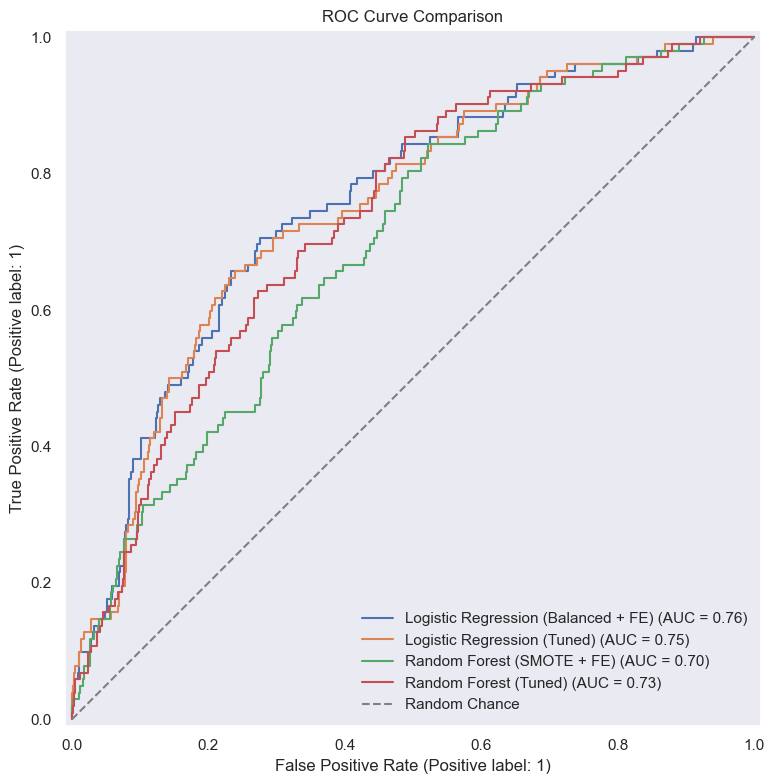

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))

for name, pipe in fitted_pipelines.items():
    RocCurveDisplay.from_estimator(
        pipe,
        X_test_fe,
        y_test_fe,
        name=name,
        ax=ax
    )

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random Chance")
ax.set_title("ROC Curve Comparison")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [62]:
models_to_plot_ = [
    ("Logistic Regression (Balanced + FE)", pipe_lr_balanced_fe),  
    ("Random Forest (SMOTE + FE)", pipe_rf_smote_fe),
    ("Logistic Regression (Tuned)", pipe_lr_tuned),
    ("Random Forest (Tuned)", pipe_rf_tuned)
]

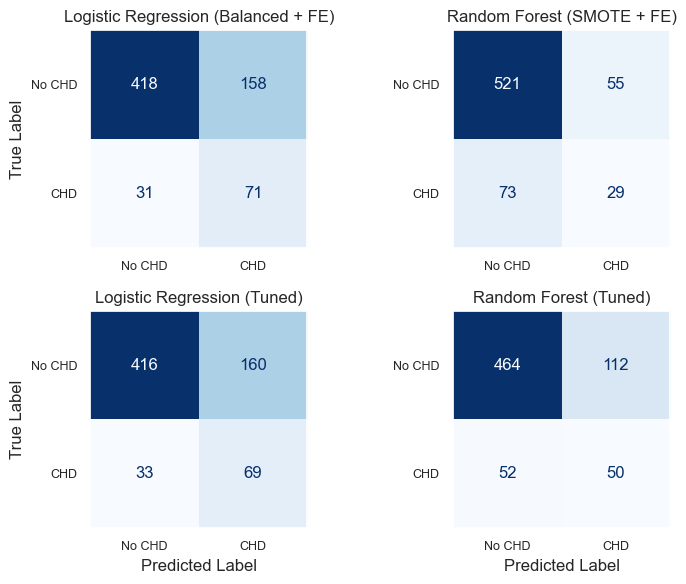

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for idx, (name, pipe) in enumerate(models_to_plot_):
    y_pred = pipe.predict(X_test_fe)

    ConfusionMatrixDisplay.from_predictions(
        y_test_fe, y_pred,
        display_labels=["No CHD", "CHD"],
        cmap="Blues",
        colorbar=False,
        ax=axes[idx]
    )

    axes[idx].set_title(name, fontsize=12)
    axes[idx].set_xlabel("Predicted Label" if idx >= 2 else '')
    axes[idx].set_ylabel("True Label" if idx % 2 == 0 else '')
    axes[idx].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

#### Hyperparameter Tuning: Insights

- **Logistic Regression (Tuned) vs Untuned**: All features dropped slightly. Recall drops : 0.696 → 0.676.
- **Random Forest (Tuned) vs Untuned**: Accuracy drops 0.811 → 0.758, but Recall improves 0.284 → 0.490.
- **Best model:** Logistic Regression (Balanced + FE). Highest Recall (0.696), F1 (0.429), and ROC AUC (0.757).
    - However, this comes at a cost: it has very low precision, meaning it generates a large number of false positives (158 healthy people are incorrectly flagged as having CHD).

---

### 5. SHAP Feature Importance

We use the best model identified: **Logistic Regression (balanced + FE)**

In [64]:
final_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor_fe),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [65]:
final_pipe.fit(X_train_fe, y_train_fe)

model_fitted = final_pipe.named_steps["model"]
preprocessor_fitted = final_pipe.named_steps["preprocessor"]

In [66]:
X_test_processed = preprocessor_fitted.transform(X_test_fe)

In [67]:
num_names = list(numerical_feats_fe)
cat_names = list(preprocessor_fitted.named_transformers_["categorical"].get_feature_names_out(categorical_feats_fe))
bin_names = list(binary_feats_fe)

In [68]:
feature_names = cat_names + num_names + bin_names

#### Visualize SHAP 

In [69]:
explainer = shap.LinearExplainer(model_fitted, X_test_processed)
shap_values = explainer(X_test_processed)

In [70]:
shap_values.feature_names = feature_names

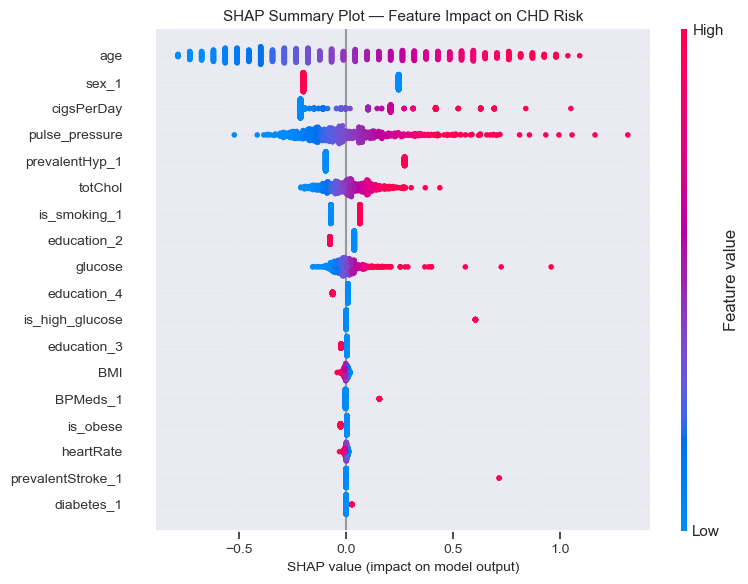

In [71]:
shap.summary_plot(
    shap_values,
    features=X_test_processed,
    feature_names=feature_names,
    show=False,
    plot_size=(8, 6)
)

ax = plt.gca()

ax.title.set_fontsize(11)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)
ax.tick_params(axis="both", labelsize=10)
ax.set_title("SHAP Summary Plot — Feature Impact on CHD Risk", fontsize=11)

plt.tight_layout()
plt.show()

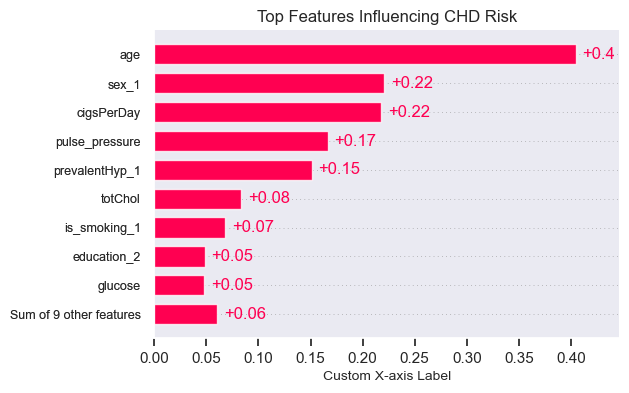

In [72]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values, ax=ax, show=False)

ax.set_title("Top Features Influencing CHD Risk", fontsize=12)
ax.set_xlabel("Custom X-axis Label", fontsize=10)
ax.tick_params(axis='y', labelsize=9) 

plt.show()

#### SHAP Insights:
1. **Age – The strongest predictor**; older patients have substantially higher risk.
2. Sex – **Males** have higher early CHD risk than females.
3. **Smoking** (cigsPerDay / is_smoking_1) – Current smokers and heavier smoking strongly increase risk.
4. Blood Pressure (pulse_pressure / BPMeds_1) – **Higher pulse pressure** and use of blood pressure medication indicate elevated risk.
5. **Cholesterol** (totChol) – Higher total cholesterol contributes to higher CHD risk.
6. **Glucose** (glucose / is_high_glucose) – Elevated glucose modestly increases risk.
7. Other conditions – Diabetes, obesity, and previous stroke have smaller but positive effects.

---

### 6. Model Generalization Check

Since the Logistic Regression (Balanced + Feature Engineering) model achieved the highest recall, it is important to verify whether this improvement reflects **true generalization** or potential **overfitting**.

We will check:
1. The difference between **training** and **test evaluation metrics**.
2. The **cross-validation recall** stability across folds.

In [73]:
best_pipe = pipe_lr_balanced_fe

In [74]:
y_pred_train = best_pipe.predict(X_train_fe)
y_pred_test  = best_pipe.predict(X_test_fe)

#### 6.1. Train, test evaluation metrics

In [75]:
train_metrics = {
    "Recall": recall_score(y_train_fe, y_pred_train),
    "Accuracy": accuracy_score(y_train_fe, y_pred_train),
    "Precision": precision_score(y_train_fe, y_pred_train),
    "F1-score": f1_score(y_train_fe, y_pred_train),
    "ROC AUC": roc_auc_score(y_train_fe, best_pipe.predict_proba(X_train_fe)[:, 1]),
}

test_metrics = {
    "Recall": recall_score(y_test_fe, y_pred_test),
    "Accuracy": accuracy_score(y_test_fe, y_pred_test),
    "Precision": precision_score(y_test_fe, y_pred_test),
    "F1-score": f1_score(y_test_fe, y_pred_test),
    "ROC AUC": roc_auc_score(y_test_fe, best_pipe.predict_proba(X_test_fe)[:, 1]),
}

metrics_df = pd.DataFrame({
    "Train": train_metrics,
    "Test": test_metrics
})
metrics_df["Difference"] = (metrics_df["Test"] - metrics_df["Train"]).round(3)
metrics_df = metrics_df.round(3)

metrics_df

,Train,Test,Difference
Recall,0.657,0.696,0.039
Accuracy,0.666,0.721,0.055
Precision,0.259,0.310,0.051
F1-score,0.372,0.429,0.057
ROC AUC,0.725,0.757,0.032


#### 6.2. Cross Validation

In [76]:
cv_scores = cross_val_score(best_pipe, X_fe, y_fe, cv=5, scoring="recall")

cv_df = pd.DataFrame({
    "Fold": range(1, len(cv_scores) + 1),
    "Recall": cv_scores
})
cv_summary = pd.DataFrame({
    "Mean Recall": [cv_scores.mean()],
    "Std Recall": [cv_scores.std()]
}).round(3)

display(cv_df.round(3))
display(cv_summary)

,Fold,Recall
0,1,0.637
1,2,0.618
2,3,0.667
3,4,0.637
4,5,0.716


,Mean Recall,Std Recall
0,0.655,0.034
